In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

C:\Users\elsha\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\elsha\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


### Collecting the data (Step 1)

In [4]:
df = pd.read_csv('../data/jobs.csv')
df.head()

,country,title,text
0,AT,Inform,https://www.linkedin.com/company/global-blue/l...
1,AT,Architect,https://www.linkedin.com/jobs/view/2589036509/...
2,AT,Manager,www.linkedin.com/jobs/view/2540581439/\n\nInfo...
3,AT,Analyst,https://www.linkedin.com/jobs/view/2997674064\...
4,AT,Engineer,https://www.linkedin.com/jobs/view/3020920801\...


### Preprocess the data (Step 2)

In [5]:
nlp = en_core_web_md.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

tokens = []
for summary in nlp.pipe(df['text']):
    proj_tok= [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

In [8]:
df['tokens'] = tokens
df['tokens']

0      [information, technology, security, manager, g...
1      [information, security, architect, copmany, sw...
2      [information, technology, security, manager, c...
3      [threat, detection, analyst, company, radar, c...
4      [security, engineer, company, global, blue, lo...
                             ...                        
116    [cyber, security, incident, responder, company...
117    [cybersecurity, professional, active, director...
118    [cyber, security, developer, job, strong, inte...
119    [cybersecurity, professional, active, director...
120    [incident, response, engineer, curious, ikea, ...
Name: tokens, Length: 121, dtype: object

### Create dictionary and corpus (Step 3)

In [9]:
dictionary = Dictionary(df['tokens'])

In [14]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

We are now ready to construct the corpus using the dictionary from above and the doc2bow function. The function doc2bow() simply counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a sparse vector:


In [15]:
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

### Model building (Step 4)

In [16]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

#### Calculating the coherence score using C_umass

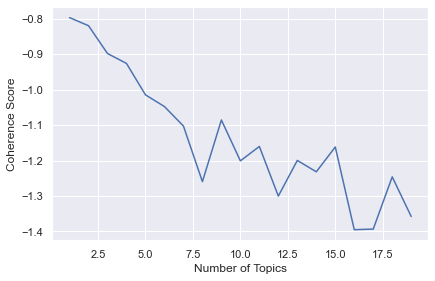

In [17]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

#### Calculating the coherence score using C_v:

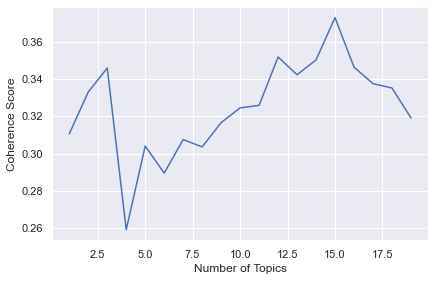

In [19]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [34]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)

In [35]:
lda_model.print_topics()

[(0,
  '0.016*"product" + 0.013*"strong" + 0.011*"design" + 0.010*"software" + 0.010*"new" + 0.009*"developer" + 0.009*"expect" + 0.008*"tool" + 0.008*"infrastructure" + 0.008*"quality"'),
 (1,
  '0.024*"incident" + 0.020*"threat" + 0.016*"response" + 0.013*"cloud" + 0.013*"analysis" + 0.011*"computer" + 0.010*"understanding" + 0.008*"detection" + 0.008*"cyber" + 0.008*"able"'),
 (2,
  '0.027*"application" + 0.027*"testing" + 0.026*"vulnerability" + 0.022*"software" + 0.020*"penetration" + 0.017*"engineer" + 0.014*"code" + 0.013*"tool" + 0.011*"web" + 0.009*"engineering"'),
 (3,
  '0.015*"infrastructure" + 0.012*"design" + 0.012*"service" + 0.010*"new" + 0.009*"include" + 0.009*"professional" + 0.008*"cyber" + 0.008*"implementation" + 0.008*"tool" + 0.007*"engineer"'),
 (4,
  '0.017*"risk" + 0.011*"cyber" + 0.011*"customer" + 0.010*"compliance" + 0.010*"control" + 0.009*"service" + 0.008*"requirement" + 0.008*"relate" + 0.008*"location" + 0.007*"services"')]

In [26]:
df['text'][1]

'https://www.linkedin.com/jobs/view/2589036509/\n\nInformation Security Architect\n\nCopmany: SWAROVSKI  \nLocation: Wattens, Tyrol, Austria\nEmployment Type: Full-time\nIndustry: Luxury Goods & Jewelry\nSize: 10,001+ employees\n\n\nReference Number R-57255\n\nYou will be part of an international team, based in Wattens/Austria, and will be responsible to coordinate the overall Information Security Program and to oversee the evolution of the information security policies and controls. This includes ensuring a coordinated execution and evolution of the Information Security Program, in line with the information security strategic objectives.\n\nAbout The Job\n\n\ncoordinate the Information Security Program\ndefine the information security policy and control framework, and oversee corporate-wide information security policies, controls and services, and their evolution\ndefine an overall reporting framework and KPIs for the Information Security Program\ndefine the Information Security Aware

In [27]:
lda_model[corpus][1]

[(0, 0.9949639)]

In [28]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

C:\Users\elsha\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [31]:
df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df['text']))]

In [33]:
df.topic.value_counts()

0    107
1     14
Name: topic, dtype: int64